In [1]:
import torch
import monai
import numpy as np
import nibabel as nib
from glob import glob

from monai.transforms import (
    Activations,
    AsChannelFirstD,
    AddChannel,
    AsDiscrete,
    Compose,
    LoadImage,
    RandRotate90,
    RandSpatialCrop,
    ScaleIntensity,
    EnsureType,
    Resized
)
from monai.data import (
    ArrayDataset, GridPatchDataset, create_test_image_3d, PatchIter) #Aparently this allow to read direcly a set of niftis
from monai.utils import first
from matplotlib import pyplot as plt
from monai.metrics import DiceMetric
from torch.utils.tensorboard import SummaryWriter


In [2]:
#loading volume paths
LOCATION = 'scan' #laptop
if LOCATION == 'scan':
    isles_data_root = '/str/data/ASAP/ISLES2018_Training/TRAINING/'
if LOCATION == 'laptop':
    isles_data_root = '/media/ASAP/ISLES2018_Training/TRAINING/'

cbf_paths = sorted(glob(isles_data_root+'/**/*CBF*/*.nii'))
tmax_paths = sorted(glob(isles_data_root+'/**/*Tmax*/*.nii'))
lbl_paths = sorted(glob(isles_data_root+'*/*OT*/*nii'))

len(cbf_paths), len(tmax_paths), len(lbl_paths)

(94, 94, 94)

In [3]:
#creating the dataloader for 10 ISLES volumes using the T_max and the CBF
#For cbf we are windowing 1-1024
#For tmax we'll window 0-60
imtrans = Compose(
    [   LoadImage(image_only=True),
        ScaleIntensity(minv=0.0, maxv=1200),
        AddChannel(),
        RandSpatialCrop((224, 224,1), random_size=False),
        EnsureType(),
        #Resized
    ]
)

segtrans = Compose(
    [   LoadImage(image_only=True),
        AddChannel(),
        RandSpatialCrop((224, 224,1), random_size=False),
        EnsureType(),
        #Resized
    ]
)


In [4]:
ds      = ArrayDataset(cbf_paths, imtrans, lbl_paths, segtrans)
loader = torch.utils.data.DataLoader(
    ds, batch_size=1, num_workers=1, pin_memory=torch.cuda.is_available()
)
im, seg = first(loader)
print(im.shape, seg.shape)
print(np.histogram(seg[0,0,:,:,0]))
print(im.max())

torch.Size([1, 1, 224, 224, 1]) torch.Size([1, 1, 224, 224, 1])
(array([49671,     0,     0,     0,     0,     0,     0,     0,     0,
         505]), array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
      dtype=float32))
tensor(528.8104)


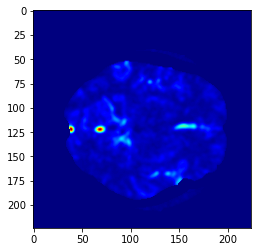

In [5]:
plt.imshow(im[0,0,:,:,0],cmap='jet')

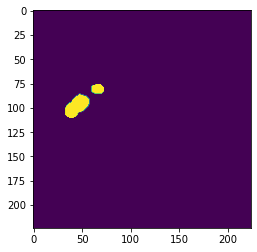

In [6]:
plt.imshow(seg[0,0,:,:,0])

In [7]:
dice_metric = DiceMetric(include_background=False, reduction="mean", get_not_nans=False)

In [8]:
post_trans = Compose([EnsureType(), Activations(sigmoid=True), AsDiscrete(threshold=True)])

/home/otarola/anaconda3/envs/fed/lib/python3.9/site-packages/monai/transforms/post/array.py:182: UserWarning: `threshold_values=True/False` is deprecated, please use `threshold=value` instead.
  warnings.warn("`threshold_values=True/False` is deprecated, please use `threshold=value` instead.")


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [10]:
model = monai.networks.nets.UNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    channels=(16, 32, 64, 128),
    strides=(2, 2, 2),
    kernel_size = (3,3),
    #dropout = 0.2,
    num_res_units=2,
).to(device)


In [11]:
loss_function = monai.losses.DiceLoss(sigmoid=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-3)

In [12]:
# start a typical PyTorch training
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = list()
metric_values = list()
writer = SummaryWriter()

In [32]:
batch_data = next(iter(loader))
inputs, labels = torch.swapaxes(batch_data[0][0], 1, -1).to(device), torch.swapaxes(batch_data[1][0], 1, -1).to(device).to(device)
print(inputs.shape,labels.shape)

torch.Size([1, 1, 224, 224]) torch.Size([1, 1, 224, 224])


In [14]:
model.train()

UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (adn): ADN(
            (N): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit1): Convolution(
          (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (adn): ADN(
            (N): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
      )
      (residual): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): ResidualUnit(
          (conv): Sequential(
            (unit

In [15]:
#Testing that the model works in one iteration
optimizer.zero_grad()
outputs = model(inputs)
loss = loss_function(outputs, labels)
loss.backward()
optimizer.step()

In [16]:
for epoch in range(100):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{10}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in loader:
        step += 1
        #inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        #Swaping axes to have a batch of Batch_size, Channels, width and height
        inputs, labels = torch.swapaxes(batch_data[0][0], 1, -1).to(device), torch.swapaxes(batch_data[1][0], 1, -1).to(device).to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_len = len(loader) // loader.batch_size
        #print(f"{step}/{epoch_len}, train_loss: {loss.item():.4f}")
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")
    

----------
epoch 1/10
epoch 1 average loss: 0.9518
----------
epoch 2/10
epoch 2 average loss: 0.9279
----------
epoch 3/10
epoch 3 average loss: 0.9217
----------
epoch 4/10
epoch 4 average loss: 0.9070
----------
epoch 5/10
epoch 5 average loss: 0.8965
----------
epoch 6/10
epoch 6 average loss: 0.8819
----------
epoch 7/10
epoch 7 average loss: 0.8600
----------
epoch 8/10
epoch 8 average loss: 0.8459
----------
epoch 9/10
epoch 9 average loss: 0.8160
----------
epoch 10/10
epoch 10 average loss: 0.7971
----------
epoch 11/10
epoch 11 average loss: 0.7925
----------
epoch 12/10
epoch 12 average loss: 0.7532
----------
epoch 13/10
epoch 13 average loss: 0.7654
----------
epoch 14/10
epoch 14 average loss: 0.7199
----------
epoch 15/10
epoch 15 average loss: 0.6969
----------
epoch 16/10
epoch 16 average loss: 0.6797
----------
epoch 17/10
epoch 17 average loss: 0.6678
----------
epoch 18/10
epoch 18 average loss: 0.6673
----------
epoch 19/10
epoch 19 average loss: 0.6564
----------


In [70]:
batch_data = first(loader)
inputs, labels = torch.swapaxes(batch_data[0][0], 1, -1).to(device), torch.swapaxes(batch_data[1][0], 1, -1).to(device).to(device)
print(inputs.shape,labels.shape)



torch.Size([1, 1, 224, 224]) torch.Size([1, 1, 224, 224])


In [71]:
outputs = model(inputs)

outputs.shape

torch.Size([1, 1, 224, 224])

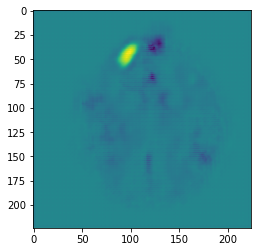

In [72]:
plt.imshow(outputs[0,0,:,:].cpu().detach().numpy())

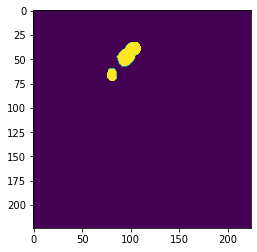

In [73]:
plt.imshow(labels[0,0,0:,:].cpu().detach().numpy())

In [30]:
labels[0,0:,:].shape

torch.Size([1, 224, 224])